In [66]:
# Magic + imports likely common across all notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
# Set reference for util modules
import sys
sys.path.append('/home/jovyan/odc-hub/')
# Generic python
import matplotlib.pyplot as plt
import numpy as np
# Bonus vector manipulation
import pandas as pd
import geopandas as gpd
from shapely import wkt
from datetime import datetime

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# **Sentinel-2 WOFS Product Creation**

### Config

Import required DC utils

In [67]:
import datacube
# DC utilities
#from utils_dcal.data_cube_utilities.clean_mask import landsat_qa_clean_mask
from utils_dcal.data_cube_utilities.dc_water_classifier import wofs_classify
from utils_dcal.data_cube_utilities.import_export import export_xarray_to_netcdf

#SAC utilities
from utils_sac.clean_mask import landsat_qa_clean_mask
from utils_sac.interactive_maps import display_map

Define aoi via wkt polygon (could be subbed or shapefile)

In [68]:
aoi_wkt = "POLYGON((178.12 -18.25,178.15 -18.25,178.15 -18.27,178.12 -18.27,178.12 -18.25))"
aoi = gpd.GeoDataFrame(pd.DataFrame({'geoms':[wkt.loads(aoi_wkt)]}), geometry='geoms')

In [69]:
dc = datacube.Datacube(app="na")

In [70]:
area_json = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
                aoi.bounds.minx.values[0],
                aoi.bounds.maxy.values[0]
            ],
            [
                aoi.bounds.maxx.values[0],
                aoi.bounds.maxy.values[0]
            ],
            [
                aoi.bounds.maxx.values[0],
                aoi.bounds.miny.values[0]
            ],
            [
                aoi.bounds.minx.values[0],
                aoi.bounds.miny.values[0]
            ],
            [
                aoi.bounds.minx.values[0],
                aoi.bounds.maxy.values[0]
            ]
          ]
        ]
      }
    }
  ]
}

In [71]:
lons, lats = zip(*area_json["features"][0]["geometry"]["coordinates"][0])
lat_extents = (min(lats), max(lats))
lon_extents = (min(lons), max(lons))
print("Lat:", lat_extents, "\n"
      "Lon:", lon_extents)

Lat: (-18.27, -18.25) 
Lon: (178.12, 178.15)


In [72]:
display_map(latitude = lat_extents, longitude = lon_extents)

### Load Data

Generic query specs

In [73]:
from datetime import datetime

query = dict(   latitude = lat_extents,
                longitude = lon_extents,
                output_crs = "EPSG:32760",
                time = (datetime(2018,12,15), datetime(2019,1,1)),
                resolution = (10,10))

Dataset-specifics

In [74]:
scenes = dc.load(product="s2_esa_sr_granule",
               group_by='solar_day',
               measurements = ["green","red","blue","nir","swir_1","swir_2","coastal_aerosol","scene_classification"],
               **query)

In [75]:
scenes['swir1']=scenes.swir_1
scenes['swir2']=scenes.swir_2
scenes = scenes.drop('swir_1')
scenes = scenes.drop('swir_2')

In [76]:
scenes

<xarray.Dataset>
Dimensions:               (time: 7, x: 319, y: 225)
Coordinates:
  * time                  (time) datetime64[ns] 2018-12-15T22:19:31 ... 2018-12-30T22:19:39
  * y                     (y) float64 7.98e+06 7.98e+06 ... 7.982e+06 7.982e+06
  * x                     (x) float64 6.184e+05 6.184e+05 ... 6.216e+05
Data variables:
    green                 (time, y, x) uint16 1714 1642 1658 ... 2396 2412 2414
    red                   (time, y, x) uint16 1606 1530 1516 ... 2182 2178 2170
    blue                  (time, y, x) uint16 1326 1308 1306 ... 2254 2266 2254
    nir                   (time, y, x) uint16 1262 1158 1236 ... 2984 2990 2974
    coastal_aerosol       (time, y, x) uint16 1171 1171 1171 ... 2734 2734 2734
    scene_classification  (time, y, x) uint8 8 6 6 6 6 6 6 6 ... 8 8 8 8 8 8 8 8
    swir1                 (time, y, x) uint16 1553 1553 1553 ... 1303 1303 1303
    swir2                 (time, y, x) uint16 868 735 735 731 ... 1966 1954 1954
Attributes:
    

Check loaded

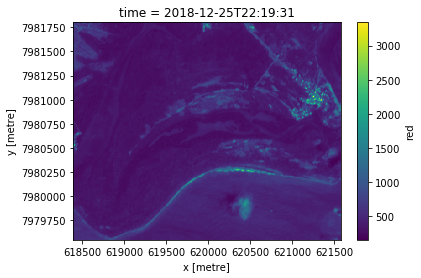

In [81]:
scenes.isel(time = 4).red.plot();

Create + apply 'cleansky' mask

In [82]:

clearsky_masks = landsat_qa_clean_mask(scenes, 'SENTINEL_2')
clearsky_scenes = scenes.where(clearsky_masks)

Apply wofs classification

In [83]:
water_classes = wofs_classify(scenes, no_data = np.nan, x_coord='x', y_coord = "y")

Visualise wofs summary product

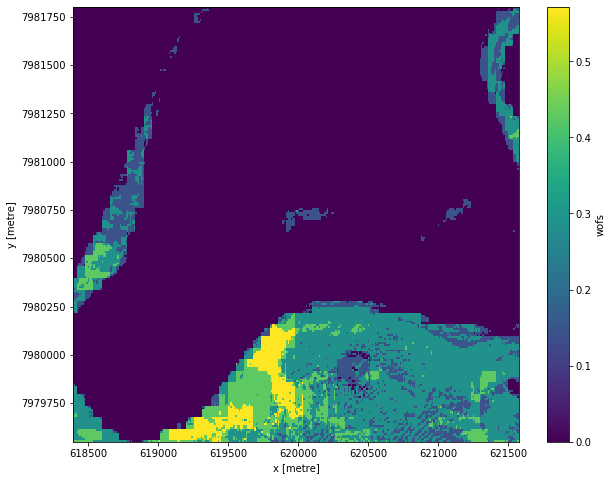

In [84]:
plt.figure(figsize = (10,8))
water_classes.wofs.mean(dim = 'time').plot()